In [161]:
import pandas as pd
import random as random
import numpy as np
import math as math
import matplotlib.pyplot as plt

# Pretty and Not Messy Code

## Step 1. Defining variables 

Knapsack problem:
* n - number of items to pack
* total_weight - maximum weight allowed to pack
* reward - value of a package 
* weight - weight of a package
* population_size

TSP:
* n_cities - number of cities on a unit circle
* population_size_cities

In [162]:
# # Knapsack problem:

# n = 4
# total_weight = 20
# reward  = [random.randint(1, 10) for _ in range(n)] # range(1,10)
# weight = [random.randint(1, 10) for _ in range(n)] # range(1,10)
# population_size = 10

# # Print to check
# print(weight)
# print(reward)

In [163]:
# TSP:
n_cities = 4
population_size_cities = 10

crossover_prob_cities = 0.8
mutation_prob_cities = 0.2
n_generations = 20

# Step 2. Create population

Knapsack problem:
Given the number of parcels, create all possible binary strings. Then randomly choose k binary strings. These are our initial population. Create Filter function that removes elemts that exceed the weight limit. Apply it before the first iteration. In the future, apply it after every next evolutionary step.

TSP:
* Add index[0] to index[len(n) + 1]
* Randomly shuffle numbers from 1 to n - do it k times (k<n!) - now we have population size k

In [164]:
# Knapsack problem:

def generate_binary_strings(n, population_size=10):
    '''
    Input:
    Output:
    '''
    if n == 0:
        return ['']
    else:
        previous_strings = generate_binary_strings(n - 1)
        new_strings = [string + '0' for string in previous_strings] + [string + '1' for string in previous_strings]
        population = random.sample(new_strings, min(population_size, len(new_strings)))
        return population
    

### Sanity pre-filtering 
# In order to reduce the intial population to hopefully save some time, we firstly check if there is an individual in the population which weight exceeds the total weight allowed
def pre_filter(n, total_weight, weight, filtered_population):
    for indiv in filtered_population:
        indiv_weight = 0
        for i in range(n):
            if indiv[i] == '1':
                indiv_weight += weight[i]
        if indiv_weight > total_weight:
            filtered_population.remove(indiv)
    return filtered_population



In [165]:
# TSP

def generate_initial_population(n, k):
    ''' 
    Function to generate the initial population

    Input:
    - n: Number of cities
    - k: Population size

    Output:
    - List of populations, each population being a list of integers representing a tour.
    '''
    population = []
    for _ in range(k):

        # Generate a random tour (each city represented by a number)
        tour = list(range(n))
        random.shuffle(tour)

        # Ensure the tour ends where it started
        tour.append(tour[0])
        population.append(tour)
        
    print(population)
    return population

def generate_distance_matrix(n):
    """
    Generates a random distance matrix for the TSP.

    Input:
    - n (int): The number of cities.

    Output:
    - dist_matrix (list of lists): A 2D list representing the distance matrix
    """
    dist_matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            dist_matrix[i][j] = random.randint(1, 100)  # Random integer distance between 1 and 100
            dist_matrix[j][i] = dist_matrix[i][j]  # Distance is symmetric
    return dist_matrix

# Step 3. Compute Fitness

Knapsack Problem 
* Function to compute total value of a given individual
* Compute Fitness - calculate total value of each individual by summing the values of each parcel that is included
* Selection (for future crossover) - use Roulette Wheel to choose 2 parents

TSP:
* Function to compute distance between city1 & city2 
* Compute Fitness - sum of distances per individual
* Selection (for future crossover) - use Roulette Wheel to choose 2 parents

In [166]:
# Knapsack:

# indiv_reward_list = []

def fitness(n, reward, filtered_population, indiv_reward_list):
    for indiv in filtered_population:
        indiv_reward = 0
        for i in range(n):
            if indiv[i] == '1':
                indiv_reward += reward[i]
        indiv_reward_list.append(indiv_reward)
    return indiv_reward_list

# Roulette Wheel part goes here

def roulette_wheel_selection(population, fitness_probs):
    # Calculate the cumulative sum of fitness probabilities
    cumsum_probs = fitness_probs.cumsum()

    random_prob = np.random.uniform(0, 1)
    
    # Find the index of the first element in the cumulative sum array
    # greater than the random probability
    selected_index = np.argmax(cumsum_probs > random_prob)

    selected_individual = population[selected_index]
    
    return selected_individual

def heavy_kiddo(kid, n, total_weight, weight):
    indiv_weight = 0
    for i in range(n):
        if kid[i] == '1':
            indiv_weight += weight[i]
    if indiv_weight > total_weight:
        return True
    return False

In [167]:
def compute_distance(tour, dist_matrix):
    """
    Computes the total distance traveled in a tour using the randomly generated distance matrix.

    Input:
    - tour (list of ints): A list representing the tour, where each element is a city index.
    - dist_matrix (list of lists): A 2D list representing the distance matrix

    Output:
    - distance (int): The total distance traveled in the tour.
    """
    distance = 0
    for i in range(len(tour) - 1):
        city1 = tour[i]
        city2 = tour[i + 1]
        distance += dist_matrix[city1][city2]
    return distance

def compute_fitness(population, dist_matrix):
    """
    Computes the fitness score (total distance) of each individual in the population.

    Input:
    - population (list of lists): The population of tours
    - dist_matrix (list of lists): A 2D list representing the distance matrix

    Output:
    - fitness_scores (list of floats): A list containing the fitness score (total distance)
      of each individual in the population.
    """
    fitness_scores = []
    for individual in population:
        fitness_scores.append(compute_distance(individual, dist_matrix))
    return fitness_scores


def roulette_wheel_selection(population, fitness_scores):
    """
    Performs selection using the Roulette Wheel method.

    Input:
    - population (list of lists): The population of tours
    - fitness_scores (list of floats): A list containing the fitness score (total distance)
      of each individual in the population.

    Output:
    - selected (list of lists): A list containing the selected individuals (tours) from the population.
    """
    total_fitness = sum(fitness_scores)
    selection_probs = [fit / total_fitness for fit in fitness_scores]
    selected = random.choices(population, weights=selection_probs, k=2)
    return selected


# Step 4. Crossover

Knapsack problem:
* Create and use Double point crossover

TSP:
* Create and use Cycle crossover

In [168]:
# Knapsack:

def double_point_crossover(parent1, parent2, prob_double_point_crossover, mutation_prob):

    # print("Parents",parent1, parent2)

    # Check if crossover happens
    rand = random.random()
    # print("Random number", rand)

    if rand <= prob_double_point_crossover:
        # Add crossover switch
        # print("Crossover started")
        # Choose two random crossover points
        point1 = random.randint(0, len(parent1) - 1)
        point2 = random.randint(point1, len(parent1)-1)
        # print("Points", point1, point2)

        # Perform crossover
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]

        # print("Kids",child1, child2)

        rand = random.random()

        if rand <= mutation_prob:
            child1, child2 = mutation(child1, child2)

        return child1, child2

    else:
        rand = random.random()

        if rand <= mutation_prob:
            parent1, parent2 = mutation(parent1, parent2)
            # print("Mutation happened", parent1, parent2)

        return parent1, parent2


# Knapsack:

def mutation(offspring1, offspring2):

     #print("Before mutation", offspring1, offspring2)

    random_child = random.choice(['1', '2'])
    if random_child == '1':
        mutated = offspring1
    else:
        mutated = offspring2

    point = random.randint(0, len(offspring1) - 1)

    # print("Mutated point", point)

    # Convert the string to a list of characters
    mutated_list = list(mutated)

    # Change the character at the selected index
    mutated_list[point] = '0' if mutated_list[point] == '1' else '1'

    # Convert the list back to a string
    mutated = ''.join(mutated_list)

    if random_child == '1':
        # print("After mutation", mutated, offspring2)
        return mutated, offspring2
    else:
        # print("After mutation", offspring1, mutated)
        return offspring1, mutated


In [169]:
# TSP

def cycle_crossover(parent1, parent2):
    child = [-1] * len(parent1)
    idx = random.randint(0, len(parent1) - 1)
    
    while True:
        child[idx] = parent1[idx]
        corresponding_city = parent2[idx]
        idx = parent1.index(corresponding_city)
        if child[idx] != -1:
            break
    
    for i in range(len(parent2)):
        if child[i] == -1:
            child[i] = parent2[i]
    
    return [child]  # Return offspring as a list of lists



# Step 5. Mutation

Knapsack: 
* Mutation - switch 0 to 1 or 1 to 0 in a random bit of an individual

TSP:
* Mutation - swap 2 numbers in an indivual

Мутация - внутри ребенка; кроссовер - свап родителей 

In [170]:
# Knapsack:

def mutation(offspring1, offspring2):

     #print("Before mutation", offspring1, offspring2)

    random_child = random.choice(['1', '2'])
    if random_child == '1':
        mutated = offspring1
    else:
        mutated = offspring2

    point = random.randint(0, len(offspring1) - 1)

    # print("Mutated point", point)

    # Convert the string to a list of characters
    mutated_list = list(mutated)

    # Change the character at the selected index
    mutated_list[point] = '0' if mutated_list[point] == '1' else '1'

    # Convert the list back to a string
    mutated = ''.join(mutated_list)

    if random_child == '1':
        # print("After mutation", mutated, offspring2)
        return mutated, offspring2
    else:
        # print("After mutation", offspring1, mutated)
        return offspring1, mutated

In [171]:
def swap_mutation(tour):
    """
    Performs Swap Mutation on a tour.

    Parameters:
    - tour (list): The tour to be mutated.

    Returns:
    - mutated_tour (list): The mutated tour.
    """
    # Select two distinct random indices for swapping
    index1, index2 = random.sample(range(len(tour)), 2)

    # Perform swap mutation
    tour[index1], tour[index2] = tour[index2], tour[index1]

    return tour


# Step 6. Putting everything together

## Knapsack

here goes knapsack comment


Weights of parcels: [2, 1, 2, 10, 9]
Rewards for parcels: [4, 6, 7, 3, 6]
Population: ['10111', '01001', '11010', '00101', '10101', '00100', '01000', '11111', '00011', '11011', '10100', '01101', '10110', '10001', '01011', '01010', '01100', '00010', '10000', '11110']
Population after first filtering: ['01001', '11010', '00101', '10101', '00100', '01000', '00011', '10100', '01101', '10110', '10001', '01011', '01010', '01100', '00010', '10000', '11110']
Population size was reduced to 98.3
iteration  0
Current population ['01001', '11010', '00101', '10101', '00100', '01000', '00011', '10100', '01101', '10110', '10001', '01011', '01010', '01100', '00010', '10000', '11110']
Its reward list [12, 13, 13, 17, 7, 6, 9, 11, 19, 14, 10, 15, 9, 13, 3, 4, 20]
Selected individual 1: 01011
Selected individual 2: 00011
Filtered population before crossover: ['01001', '11010', '00101', '10101', '00100', '01000', '10100', '01101', '10110', '10001', '01010', '01100', '00010', '10000', '11110']
iteration  1

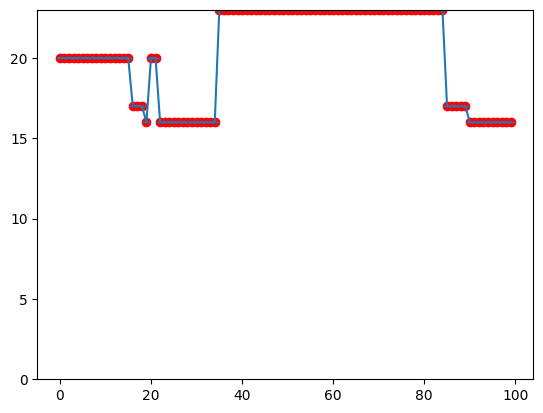

In [172]:

n = 5 # number of boxes
total_weight = 20
reward  = [random.randint(1, 10) for _ in range(n)] # range(1,10)
weight = [random.randint(1, 10) for _ in range(n)] # range(1,10)
population_size = 10

# Print to check
print("Weights of parcels:", weight)
print("Rewards for parcels:", reward)

iterations = 100
prob_double_point_crossover = 0.8
mutation_prob = 0.2
population_size = 1000


population = generate_binary_strings(n, population_size)
print("Population:", population)

filtered_population = population.copy()

filtered_population = pre_filter(n, total_weight, weight, population)
print("Population after first filtering:", filtered_population)
print("Population size was reduced to", (100 - len(filtered_population)*100/(population_size)))

initial_filtered_population_size = len(filtered_population)

fittest_over_time = []

for i in range(0, iterations):

    print("iteration ", i)

    indiv_reward_list = []
    print("Current population", filtered_population)

    # Compute gains from all individuals in current population
    indiv_reward_list = fitness(n, reward, filtered_population, indiv_reward_list)
    print("Its reward list", indiv_reward_list)

    # Compute fitness probabilities
    fitness_probs = np.array(indiv_reward_list) / sum(indiv_reward_list)

    # Perform selection and crossover
    selected_individual1, selected_individual2 = roulette_wheel_selection(filtered_population, fitness_probs)
    
    print("Selected individual 1:", selected_individual1)
    index_to_remove = filtered_population.index(selected_individual1)
    filtered_population.pop(index_to_remove)

    print("Selected individual 2:", selected_individual2)
    index_to_remove = filtered_population.index(selected_individual2)
    filtered_population.pop(index_to_remove)

    print("Filtered population before crossover:", filtered_population)

    # Apply crossover
    offspring1, offspring2 = double_point_crossover(selected_individual1, selected_individual2, prob_double_point_crossover, mutation_prob)

    if(heavy_kiddo(offspring1, n, total_weight, weight)):
        print("Kid got too heavy, we took a parent instead")
        offspring1 = selected_individual1

    if(heavy_kiddo(offspring2, n, total_weight, weight)):
        print("Kid got too heavy, we took a parent instead")
        offspring2 = selected_individual2

    filtered_population.append(offspring1)
    filtered_population.append(offspring2)

    assert(initial_filtered_population_size == len(filtered_population))

    fittest_over_time.append(indiv_reward_list[np.argmax(indiv_reward_list)])



print(fittest_over_time)
print("The fittest indiv has value:",indiv_reward_list[np.argmax(indiv_reward_list)])


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the line
ax.plot(fittest_over_time, marker='_', linestyle='-')

# Add blobs at each point
ax.scatter(range(len(fittest_over_time)), fittest_over_time, color='red')

# Set Y-axis limit from 0 to the maximum value in the array
ax.set_ylim(0, max(fittest_over_time))

# Show the plot
plt.show()

# Implement Roulette - done
# Make sure population size stays the same - done
# Add filtering for obese kids - done
# Check "population reduced by" - done
# Return fittest individual in the end - done
# Plot fittest individual over time - done
# Improve, but how - TODO maybe keep the fittest always
# Come up with experiments - TODO
# Write report on these experiments - TODO

## TSP

here goes tsp comment

NameError: name 'crossover_per' is not defined

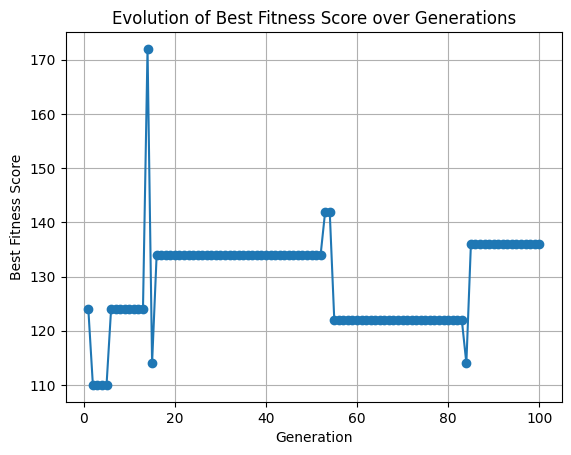

In [13]:
def genetic_algorithm(n, k, generations):
    # Generate a random distance matrix
    dist_matrix = generate_distance_matrix(n)

    # Generate initial population
    population = generate_initial_population(n, k)
    print("-----------------------------")

    best_fitness_scores = []  # List to store best fitness score at each generation

    for _ in range(generations):
        # Compute fitness
        fitness_scores = compute_fitness(population, dist_matrix)
        
        # Store the best fitness score of this generation
        best_fitness = min(fitness_scores)
        best_fitness_scores.append(best_fitness)

        # Selection
        parents = roulette_wheel_selection(population, fitness_scores)
        # Add your crossover, mutation, and replacement steps here
        # For this example, we're only showing the selection step
        print("Selected parents:", parents)
        # Extract the selected parents
        parent1, parent2 = parents

        offspring = cycle_crossover(parent1, parent2)
        print("Offspring after crossover:", offspring)

        mutation_probability = 0.1  # Example mutation probability (10%)

        # After crossover, apply mutation to each offspring with a certain probability
        for i in range(len(offspring)):
            print("Before mutation - Offspring", i, ":", offspring[i])
            
            # Check if mutation should be applied based on mutation probability
            if random.random() < mutation_probability:
                offspring[i] = swap_mutation(offspring[i])
                print("Mutation applied to Offspring", i)
            else:
                print("No mutation applied to Offspring", i)
            
            print("After mutation - Offspring", i, ":", offspring[i])
        # Update the population by removing parents and adding offspring
        # Update the population by removing parents and adding offspring
        try:
            population.remove(parent1)
        except ValueError:
            pass  # parent1 not found in population
        try:
            population.remove(parent2)
        except ValueError:
            pass  # parent2 not found in population
        population.extend(offspring)

        # Print line of dashes to differentiate between iterations
        print("-----------------------------")

    # Plotting the best fitness scores over generations
    plt.plot(range(1, generations + 1), best_fitness_scores, marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.title('Evolution of Best Fitness Score over Generations')
    plt.grid(True)
    plt.show()

# Function to call the genetic algorithm with specified parameters
def run_genetic_algorithm(n, k, generations):
    genetic_algorithm(n, k, generations)

# Example usage:
run_genetic_algorithm(4, 10, 100)  # n=4 cities, population size=10, number of generations=100


# Experiments Brainstorm

TSP: increase the number of citites aka angle change untill it starts breaking

Knapsack: Experiment ratio weight range and max weight allowed

# Outline TSP

1. Input - n - number of cities
2. Compute gamma: 360/n
3. Randomly shuffle numbers from 1 to n - do it k times (k<n!) - now we have population size k
4. Create a function that computes all distance between city1 and city2 - outputs distance
5. Compute Fitness - weight - which is a sum of distances per individual
6. Use Roulette Wheel to choose 2 parents
7. Do Cycle Crossover
8. Mutation - swap 2 cities
9. Update the population 

# Outline Knapsack
1. Input n - number of boxes; 
2. input max weight, create random values per box
3. Create all possible binary strings and choose randomly k indiv
* Create Filter function
* Use on initial population
4. Create a function that computes the value of a given indiv
5. Compute fitness - value (same as tsp)
6. Selection - Use Roulette Wheel to choose 2 parents
7. Do double point crossover 
8. Mutation - switch one 0 to 1 or 1 to 0
9. Updae the population
